In [1]:
try:
  import tensorflow as tf
except:
  !pip install tensorflow
  import tensorflow as tf

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_csv_to_dataset(csv_path, img_dir, target_size=(128, 128), batch_size=32, shuffle=True, label_map=None):
    df = pd.read_csv(csv_path)

    # Create label map
    if label_map is None:
      labels = sorted(df['class'].unique())
      label_map = {label: idx for idx, label in enumerate(labels)}

    filepaths = df['filename'].apply(lambda x: os.path.join(img_dir, x)).values
    labels = df['class'].apply(lambda x: label_map[x]).values

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def process_image(file_path, label):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        label = tf.one_hot(label, depth=len(label_map))
        return img, label

    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset, label_map

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_ds, label_map = load_csv_to_dataset(
    '/content/drive/MyDrive/Dataset/train/_annotations.csv',
    '/content/drive/MyDrive/Dataset/train',
    shuffle=True)

val_ds, _ = load_csv_to_dataset(
    '/content/drive/MyDrive/Dataset/valid/_annotations.csv',
    '/content/drive/MyDrive/Dataset/valid',
    shuffle=False, label_map = label_map)

test_ds, _ = load_csv_to_dataset(
    '/content/drive/MyDrive/Dataset/test/_annotations.csv',
    '/content/drive/MyDrive/Dataset/test',
    shuffle=False, label_map = label_map)

In [6]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/train/_annotations.csv')
labels = df['class'].apply(lambda x: label_map[x]).values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights)

Epoch 1/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 2062s 2s/step - accuracy: 0.3371 - loss: 1.3415 - val_accuracy: 0.2701 - val_loss: 1.1890
Epoch 2/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 927s 918ms/step - accuracy: 0.3056 - loss: 1.0965 - val_accuracy: 0.4424 - val_loss: 1.0268
Epoch 3/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 959s 897ms/step - accuracy: 0.4245 - loss: 0.8976 - val_accuracy: 0.5300 - val_loss: 0.9923
Epoch 4/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 890s 885ms/step - accuracy: 0.5054 - loss: 0.7635 - val_accuracy: 0.5286 - val_loss: 0.9707
Epoch 5/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 911s 875ms/step - accuracy: 0.5644 - loss: 0.7086 - val_accuracy: 0.5605 - val_loss: 0.9253
Epoch 6/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 847s 841ms/step - accuracy: 0.5926 - loss: 0.6675 - val_accuracy: 0.6176 - val_loss: 0.7752
Epoch 7/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 873s 853ms/step - accuracy: 0.6442 - loss: 0.5530 - val_accuracy: 0.5508 - val_loss: 0.9495
Epoch 8/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 855s 851ms/step - accu

In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.2f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7257 - loss: 0.7529
Test accuracy: 0.72


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

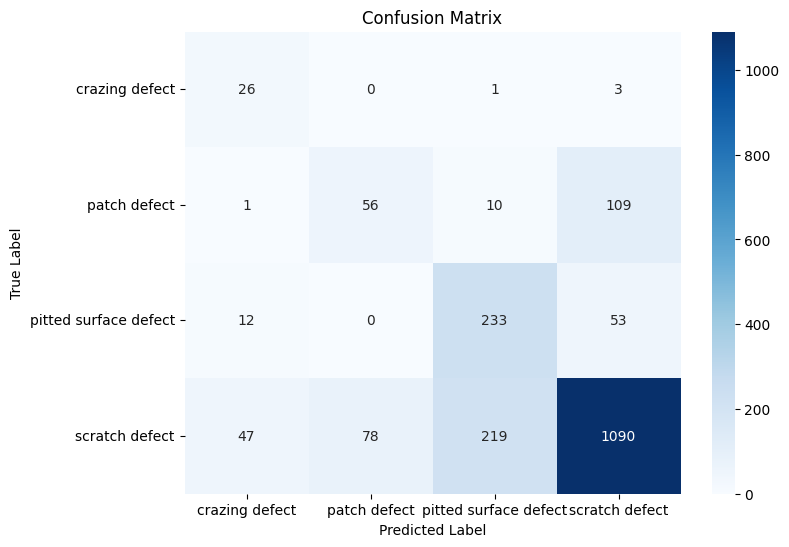

In [10]:
# Function to get predictions and ground truth labels
def get_predictions(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        # Get the ground truth labels
        y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class index

        # Get the predicted labels
        y_pred.extend(np.argmax(model.predict(images), axis=1))

    return np.array(y_true), np.array(y_pred)

# Get true labels and predicted labels
y_true, y_pred = get_predictions(model, test_ds)

# 1. Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 2. Precision
precision = precision_score(y_true, y_pred, average='weighted')  # 'weighted' to handle imbalanced classes
print(f"Precision: {precision:.4f}")

# 3. Recall
recall = recall_score(y_true, y_pred, average='weighted')  # 'weighted' to handle imbalanced classes
print(f"Recall: {recall:.4f}")

# 4. F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' to handle imbalanced classes
print(f"F1-Score: {f1:.4f}")

# 5. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [48]:
import cv2
import numpy as np
import tensorflow as tf

def process_single_image(img):
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    img_uint8 = (img * 255).astype(np.uint8)
    if img_uint8.shape[-1] == 1:
        img_uint8 = np.repeat(img_uint8, 3, axis=-1)
    gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((3,3), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)
    _, mask = cv2.threshold(closed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.dilate(mask, kernel, iterations=1)
    return mask.astype(np.uint8)

def segment_defect(img):
    img = img.numpy()
    if img.ndim == 4:
        results = []
        for i in range(img.shape[0]):
            results.append(process_single_image(img[i]))
        return np.stack(results, axis=0)
    else:
        return process_single_image(img)

def preprocess_image_tf(image, label):
    mask = tf.py_function(
        func=segment_defect,
        inp=[image],
        Tout=tf.uint8
    )
    mask.set_shape([128,128])
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.expand_dims(mask, -1)
    mask = tf.repeat(mask, 3, axis=-1)
    masked_image = image * mask
    return masked_image, label

# Unbatch -> map -> batch
seg_train_ds = train_ds.unbatch().map(preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
seg_val_ds = val_ds.unbatch().map(preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
seg_test_ds = test_ds.unbatch().map(preprocess_image_tf, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [49]:
seg_model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])
seg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
seg_history = seg_model.fit(seg_train_ds, validation_data=seg_val_ds, epochs=10, class_weight=class_weights)


Epoch 1/10
   1002/Unknown 861s 853ms/step - accuracy: 0.5019 - loss: 1.2791

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 881s 874ms/step - accuracy: 0.5018 - loss: 1.2790 - val_accuracy: 0.5208 - val_loss: 1.1011
Epoch 2/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 924s 918ms/step - accuracy: 0.5323 - loss: 0.8628 - val_accuracy: 0.5581 - val_loss: 1.0665
Epoch 3/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 868s 863ms/step - accuracy: 0.7060 - loss: 0.5546 - val_accuracy: 0.6302 - val_loss: 1.0011
Epoch 4/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 983s 923ms/step - accuracy: 0.7995 - loss: 0.4074 - val_accuracy: 0.6452 - val_loss: 1.0046
Epoch 5/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 920s 915ms/step - accuracy: 0.8309 - loss: 0.3942 - val_accuracy: 0.6873 - val_loss: 1.0175
Epoch 6/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 915s 909ms/step - accuracy: 0.8580 - loss: 0.3214 - val_accuracy: 0.6738 - val_loss: 1.0605
Epoch 7/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 913s 906ms/step - accuracy: 0.8773 - loss: 0.3084 - val_accuracy: 0.6660 - val_loss: 1.2548
Epoch 8/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 920s 915ms/step - accuracy: 0.8

In [50]:
seg_test_loss, seg_test_acc = seg_model.evaluate(seg_test_ds)
print(f"Segmentation-based Test accuracy: {seg_test_acc:.2f}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 514ms/step - accuracy: 0.7013 - loss: 0.9262
Segmentation-based Test accuracy: 0.69


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

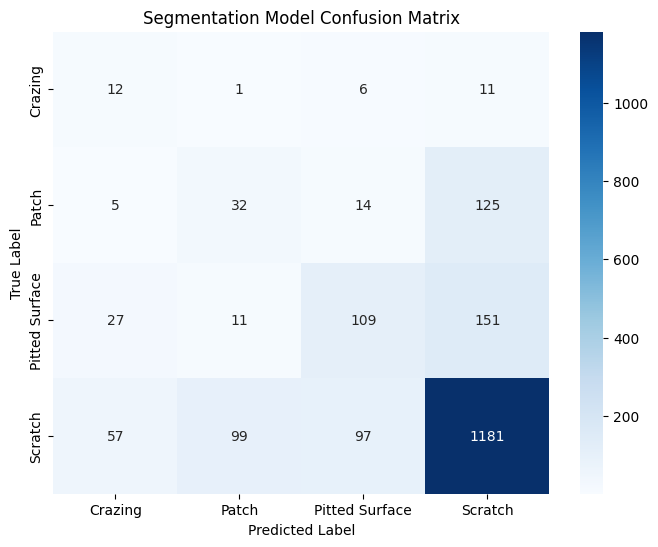

In [51]:
def get_predictions(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(model.predict(images), axis=1))
    return np.array(y_true), np.array(y_pred)

y_true_seg, y_pred_seg = get_predictions(seg_model, seg_test_ds)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_true_seg, y_pred_seg))
print("Precision:", precision_score(y_true_seg, y_pred_seg, average='weighted'))
print("Recall:", recall_score(y_true_seg, y_pred_seg, average='weighted'))
print("F1-Score:", f1_score(y_true_seg, y_pred_seg, average='weighted'))

cm = confusion_matrix(y_true_seg, y_pred_seg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Segmentation Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


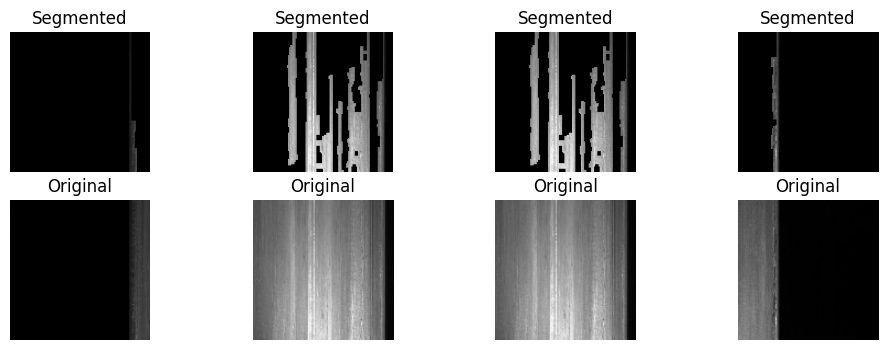

In [52]:
def show_segmentation_examples(dataset, n=3):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12,4))
        for i in range(n):
            plt.subplot(2, n, i+1)
            plt.imshow(images[i].numpy())
            plt.title("Segmented")
            plt.axis('off')
        for i in range(n):
            plt.subplot(2, n, n+i+1)
            # Get original image from test_ds (without segmentation)
            for orig_images, _ in test_ds.take(1):
                plt.imshow(orig_images[i].numpy())
                plt.title("Original")
                plt.axis('off')
        plt.show()
show_segmentation_examples(seg_test_ds, n=4)


In [53]:
print("Baseline Test accuracy:", test_acc)
print("Segmentation-based Test accuracy:", seg_test_acc)


Baseline Test accuracy: 0.7249742150306702
Segmentation-based Test accuracy: 0.6883385181427002
